In [1]:
import os
n_jobs = 64
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time

import itertools
import collections.abc
import sys
from tqdm.notebook import tqdm
# !{sys.executable} -m pip install qcircuit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.optimize import minimize
# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import Session, Batch
# from qiskit_machine_learning.optimizers import SPSA, Minimizer


from joblib import dump, load


In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)


def double_angle(quantumcircuit, num_wires,paramname='x'):
    #  creates a circuit that encodes features into wires via angle encoding with an RY then RZ gate
    #  the features are encoded 1-1 onto the qubits
    #  if more wires are passed then features the remaining wires will be filled from the beginning of the feature list
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_index = i % num_features
        quantumcircuit.ry(features[feature_index], i)
        quantumcircuit.rz(features[feature_index], i)

def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires,paramname='theta'):
    parameters = ParameterVector(paramname,num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
# def circuit(nqubits):
#     qc = QuantumCircuit(nqubits)
#     mitarai(qc,nqubits)
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     mitarai(qc,nqubits,paramname='x1')
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     HardwareEfficient(qc,nqubits)
#     qc.barrier()
#     return qc


def circuit(nqubits,RUD=1,AL=1):
    qc = QuantumCircuit(nqubits)
    for i in range(RUD):
        double_angle(qc,nqubits,paramname=f'x{i}')
        qc.barrier()
        for j in range(AL):        
            HardwareEfficient(qc,nqubits,paramname=f'theta{i}_{j}')
            qc.barrier()
    return qc

In [4]:

top=os.getcwd()
with open(os.path.join(top,'5_DDCC_train.bin'),'rb') as f:
    ddcc_train = joblib.load(f)

with open(os.path.join(top,'5_DDCC_test.bin'),'rb') as f:
    ddcc_test = joblib.load(f)

with open(os.path.join(top,'5_DDCC_scaler.bin'),'rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)
y_ddcc_train = y_ddcc_train.reshape(-1,64)
y_ddcc_test = y_ddcc_test.reshape(-1,64)


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test
scaler = ddcc_scaler

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(159, 64, 5) (40, 64, 5)
(159, 64) (40, 64)


/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
num_qubits = 5
RUD = 1
AL = 5

In [6]:
# 
qc = circuit(num_qubits,RUD,AL)

num_params = len([i for i in list(qc.parameters) if 'theta' in i.name]) // AL
generator = np.random.default_rng(12958234)
load_params = os.path.join(os.getcwd(),'state_vector_parameters.bin')

if load_params!=None:
    print('Parameters loaded')
    try:
        x0 = np.load(load_params)['x0']
    except:
        x0 = np.array(np.load(load_params,allow_pickle=True)['parameters'])
else:
    print('Parameters from scratch')
    x0 = np.tile(generator.uniform(-np.pi, np.pi, num_params),AL*RUD)




Parameters loaded


In [7]:
optimization_level = 3
shots = 1024.0
resilience_level = 1

In [8]:
# Parameters
optimization_level = "0"
resilience_level = "1"


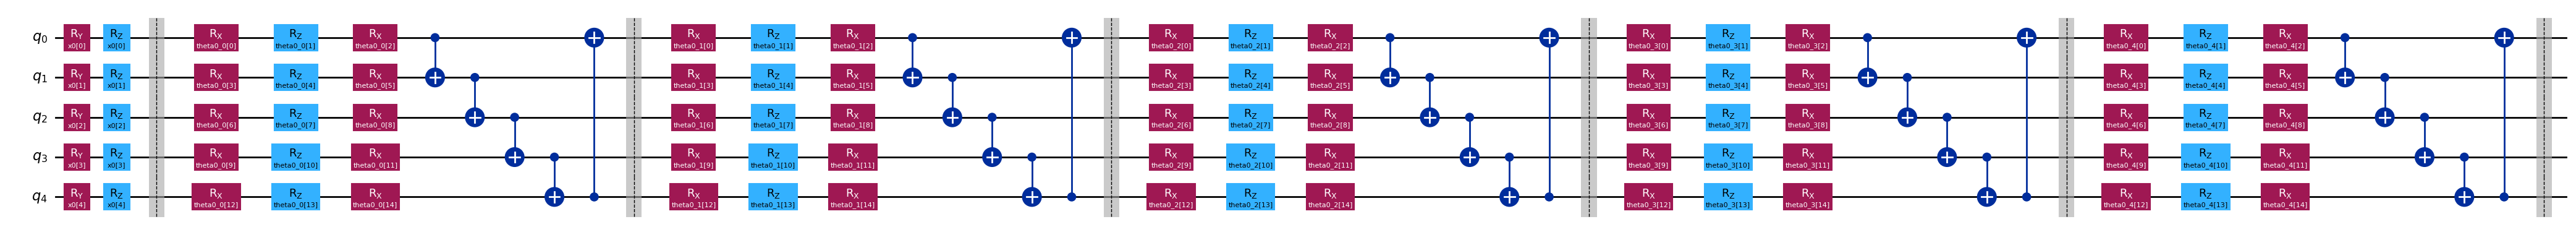

In [9]:
qc.draw('mpl', scale=1, plot_barriers=True, fold=100)

In [10]:
resilience_level = int(resilience_level)
optimization_level = int(optimization_level)
shots = int(shots)

In [11]:
back = "fake"
if back=='real':
    # Select backend
    service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
    _backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
# Generate pass manager
    pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)
    qc = pm.run(qc)
    
    
    observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
    observables = [SparsePauliOp(observables_labels)]
    
    mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
    print(mapped_observables)    
elif back=='fake':
    # Select backend
    service = QiskitRuntimeService(channel="ibm_quantum", instance='pinq-quebec-hub/univ-toronto/default')
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
    # generate a simulator that mimics the real quantum
    # system with the latest calibration results
    _backend = AerSimulator.from_backend(backend)
    
    # _backend = FakeQuebec()
    target = _backend.target

    # Generate pass manager
    pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)
    qc = pm.run(qc)
    
    
    observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
    observables = [SparsePauliOp(observables_labels)]
    
    mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
    print(mapped_observables)
else:
    observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
    observables = [SparsePauliOp(observables_labels)]
    
    mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
    print(mapped_observables)    

    _backend = "statevector"

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[1.+0.j])]


In [12]:
# qc.draw('mpl', scale=1, plot_barriers=True, fold=100)

In [13]:
def map2qiskit(ansatz, num_qubits, X):
    '''
    Map features to Qiskit Circuit
    
    parameters
    ----------
    ansatz: qiskit.circuit.quantumcircuit.QuantumCircuit
        Qiskit Quantum Circuit
        
    num_qubits: int
        Number of qubits
        
    X: numpy.ndarray
        Feature matrix

    returns
    -------
    ansatz: qiskit.circuit.quantumcircuit.QuantumCircuit
        Qiskit Quantum Circuit
    
    '''
    featparams = dict([(i,X[idx % num_qubits]) for idx,i in enumerate(ansatz.parameters) if 'x' in i.name])
    ansatz = ansatz.assign_parameters(featparams)
    return ansatz

In [14]:
def get_results(job):
    '''
    Get the results of a quantum job from IBM Quantum
    
    parameters
    ----------
    job: qiskit.primitives.primitive_job.PrimitiveJob
        Job submitted to the IBM Quantum device

    returns
    -------
    pred: numpy.ndarray
        Predicted values
    
    '''
    result = job.result()
    pred = np.vstack([r.data.evs for r in result]).flatten()
    return pred

In [15]:
def batchmap(params, ansatz, hamiltonian, _backend, index, shots=1024, resilience_level=1):
    '''
    Function to map batches

    parameters
    ----------
    params: numpy.ndarray
        Initial circuit parameters
        
    ansatz: qiskit.circuit.quantumcircuit.QuantumCircuit
        Qiskit Quantum Circuit

    hamiltonian: list
        List containing the observables
        
    _backend: qiskit_ibm_runtime backend
        Backend of choice (real or fake)

    index: int
        Index of batch
        
    shots: float or int
        Number of shots. Default is 1024.0.
    
    resilience_level: int
        Error mitigation level. Default is 1.

    returns
    -------
    y_pred: numpy.ndarray
        Predicted values    
    '''    
    if _backend!='statevector':
        with Batch(backend=_backend) as batch:
            if _backend.name!='ibm_quebec':
                jobid = str(index)
            else:
                jobid = batch.details()['id']
            estimator = Estimator(mode=batch)
            estimator.options.default_shots = shots
            estimator.options.resilience_level = resilience_level
            pub = [(a, [hamiltonian], [p]) for a, p in zip(ansatz, params)]
            result = estimator.run(pubs=pub)
            
    else:
        jobid = str(index)
        estimator = StatevectorEstimator()
        pub = [(a, [hamiltonian], [p]) for a, p in zip(ansatz, params)]
        result = estimator.run(pubs=pub)
    return jobid,result

In [16]:
def batched_pred(params, ansatz, hamiltonian, num_qubits, X, _backend, shots=1024, resilience_level=1, n_jobs=-1):
    '''
    Function to predict quantum circuits in batches

    parameters
    ----------
    params: numpy.ndarray
        Initial circuit parameters
        
    ansatz: qiskit.circuit.quantumcircuit.QuantumCircuit
        Qiskit Quantum Circuit

    hamiltonian: list
        List containing the observables
        
    num_qubits: int
        Number of qubits
        
    X: numpy.ndarray
        Feature matrix
        
    _backend: qiskit_ibm_runtime backend
        Backend of choice (real or fake)
        
    shots: float or int
        Number of shots. Default is 1024.0.
    
    resilience_level: int
        Error mitigation level. Default is 1.

    n_jobs: int
        Number of threads/cores for parallelization.

    returns
    -------
    y_pred: numpy.ndarray
        Predicted values    
    '''
    mapped_circuits = [[map2qiskit(ansatz,num_qubits,x_i) for x_i in x] for x in X]
    tiled_params = np.tile(params,(X.shape[0],X.shape[1])).reshape(X.shape[0],X.shape[1],-1)
    
    # Submit jobs
    
    t0 = time.perf_counter()
    jobs = joblib.Parallel(n_jobs=n_jobs,verbose=0, prefer="threads")(joblib.delayed(batchmap)(pars, anz, hamiltonian, _backend, idx, shots, resilience_level) for idx, (anz, pars) in tqdm(enumerate(zip(mapped_circuits,tiled_params)),desc="Mappings"))
    print(f"Submitted to device in {time.perf_counter()-t0:.4f} s")
    
    t1 = time.perf_counter()
    y_pred = np.vstack(joblib.Parallel(n_jobs=n_jobs,verbose=0, prefer="threads")(joblib.delayed(get_results)(job) for jobid, job in tqdm(jobs,desc="Running batch: ")))
    print(f"Predicted in {time.perf_counter()-t1:.4f} s")

    return y_pred

In [17]:
def cost_func(params, ansatz, hamiltonian, num_qubits, X, y, cost_history_dict, _backend, shots=1024.0, resilience_level=1, n_jobs=-1):
    """
    Cost function. Is this loss?
    
    parameters
    ----------
    params: numpy.ndarray
        Initial circuit parameters
        
    ansatz: qiskit.circuit.quantumcircuit.QuantumCircuit
        Qiskit Quantum Circuit

    hamiltonian: list
        List containing the observables
        
    num_qubits: int
        Number of qubits
        
    X: numpy.ndarray
        Feature matrix

    y: numpy.ndarray
        Target vector

    cost_history_dict: dict
        Dictionary to track the loss        
        
    _backend: qiskit_ibm_runtime backend
        Backend of choice (real or fake)
        
    shots: float or int
        Number of shots. Default is 1024.0.
    
    resilience_level: int
        Error mitigation level. Default is 1.

    n_jobs: int
        Number of threads/cores for parallelization.

    """
    t0=time.perf_counter()
    
    y_pred = batched_pred(params, ansatz, hamiltonian, num_qubits, X, _backend, shots, resilience_level, n_jobs)
    
    loss = mean_squared_error(y.flatten(),y_pred.flatten())
    r2 = r2_score(y.flatten(),y_pred.flatten())
    
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(loss)
    
    print(f"Iters. done: {cost_history_dict['iters']} Current cost: {loss} Accuracy: {r2} Time: {time.perf_counter()-t0}")
    
    with open('model_log.csv', 'a') as outfile:
        log = f"{time.asctime()},{cost_history_dict['iters']},{loss},{params}\n"
        outfile.write(log)

    save_file = 'partial_state_model.bin'
    progress = {'x': params, 'loss': loss}
    dump(progress, save_file)
  
    return loss

In [18]:
def evaluate(params, ansatz, hamiltonian, num_qubits, n_jobs, _backend, X_train, y_train, X_test=None, y_test=None, plot: bool = False, title: str = 'defult',y_scaler=None, shots=1024.0, resilience_level=1):
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    
    y_train_pred = batched_pred(params, ansatz, hamiltonian, num_qubits, X_train, _backend, shots, resilience_level, n_jobs)
    y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    y_train = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

    scores['MSE_train'] = mean_squared_error(y_train, y_train_pred)
    scores['R2_train'] = r2_score(y_train, y_train_pred)
    scores['MAE_train'] = mean_absolute_error(y_train, y_train_pred)

    y_test_pred = None
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    if y_test is not None:
        y_test_pred = batched_pred(params, ansatz, hamiltonian, num_qubits, X_test, _backend, shots, resilience_level, n_jobs)
        y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    
        scores['MSE_test'] = mean_squared_error(y_test, y_test_pred)
        scores['R2_test'] = r2_score(y_test, y_test_pred)
        scores['MAE_test'] = mean_absolute_error(y_test, y_test_pred)

    if plot:
        plt.figure()
        if y_test_pred is not None:
            plt.scatter(y_test, y_test_pred, color='b', s=10, label=f'Test, MAE = {scores["MAE_test"]:.2f}')
        plt.scatter(y_train, y_train_pred, color='r', s=10, label=f'Train, MAE = {scores["MAE_train"]:.2f}')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.axis('scaled')

        max_val = max(max(plt.xlim()), max(plt.ylim()))
        min_val = min(min(plt.xlim()), min(plt.ylim()))
        plt.xlim((min_val, max_val))
        plt.ylim((min_val, max_val))

        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        plt.plot([x_min, x_max], [y_min, y_max], 'k--', alpha=0.2, label='y=x')
        plt.legend()
        plt.savefig(title+'_plot.svg')

        if X_test.shape[1] == 1:
            plt.figure()
            plt.title(title)
            plt.scatter(X_train, y_train_pred, color='b', label='Train', s=10)
            plt.scatter(X_test, y_test_pred, color='orange', label='Test', s=10)
            plt.scatter(X_train, y_train, color='green', label='Data', s=10)
            plt.scatter(X_test, y_test, color='green', s=10)
            plt.legend()
            plt.savefig(title+'_1D_plot.svg')

    print(f'Scoring complete taking {time.time() - st} seconds. ')

    return scores, y_test_pred, y_train_pred

Mappings: 0it [00:00, ?it/s]

Submitted to device in 491.5203 s


Running batch:   0%|          | 0/159 [00:00<?, ?it/s]

Predicted in 897.9853 s
Iters. done: 1 Current cost: 0.08425204464033241 Accuracy: 0.06943095224199902 Time: 1395.2867915090173
Now scoring model... 


Mappings: 0it [00:00, ?it/s]

Submitted to device in 590.5797 s

Running batch:   0%|          | 0/159 [00:00<?, ?it/s]

Predicted in 937.6133 s


Mappings: 0it [00:00, ?it/s]

Submitted to device in 175.9639 s


Running batch:   0%|          | 0/40 [00:00<?, ?it/s]

Predicted in 240.1992 s


Scoring complete taking 1952.2411999702454 seconds. 


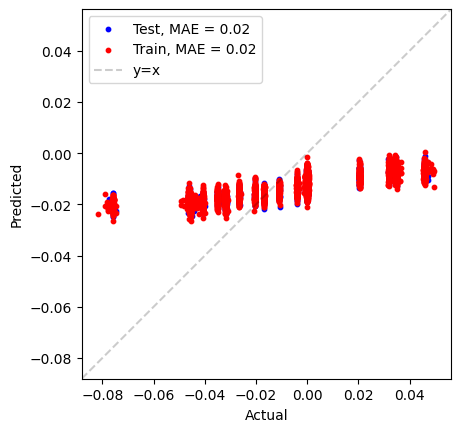

In [19]:

scores = []
with open('model_log.csv', 'w') as outfile:
    outfile.write('Time,Iteration,Cost,Parameters')
    outfile.write('\n')        


cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}





res = minimize(cost_func,
    x0,
    args=(qc, mapped_observables, num_qubits, X_train, y_train, cost_history_dict, _backend, shots, resilience_level, n_jobs),
    method="cobyla", options={'maxiter':1})  

x0 = res.x
loss = res.fun    
progress = {'x': x0, 'loss': loss}
dump(progress, 'final_state_model.bin')
os.remove('partial_state_model.bin') 

scores, y_test_pred, y_train_pred = evaluate(x0, qc, mapped_observables, num_qubits, n_jobs, _backend, X_train, y_train, X_test=X_test, y_test=y_test, plot = True, title= 'A2_HWE-CNOT',y_scaler=scaler, shots=shots, resilience_level=resilience_level)

name = 'A2_HWE-CNOT_predicted_values.csv'

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_pred, y_train, test_pred, y_test = y_train_pred.flatten().tolist(), y_train.flatten().tolist(), y_test_pred.flatten().tolist(), y_test.flatten().tolist()
df_train = pd.DataFrame({'Predicted': train_pred, 'Reference': y_train})
df_train['Data'] = 'Train'
df_test = pd.DataFrame({'Predicted': test_pred, 'Reference': y_test})
df_test['Data'] = 'Test'
df = pd.concat([df_train, df_test], ignore_index=True)
df = df[['Data', 'Predicted', 'Reference']]

df.to_csv(name, index=False)

results_title = 'A2_HWE-CNOT_results.json'
with open(results_title, 'w') as outfile:
    json.dump(scores, outfile)




In [20]:
r2_score(y_train,train_pred),mean_squared_error(y_train,train_pred)

(0.0627528377734885, 0.0003654161883450226)

In [21]:
r2_score(y_test,test_pred),mean_squared_error(y_test,test_pred)

(0.0674227094288129, 0.00036232918709195813)

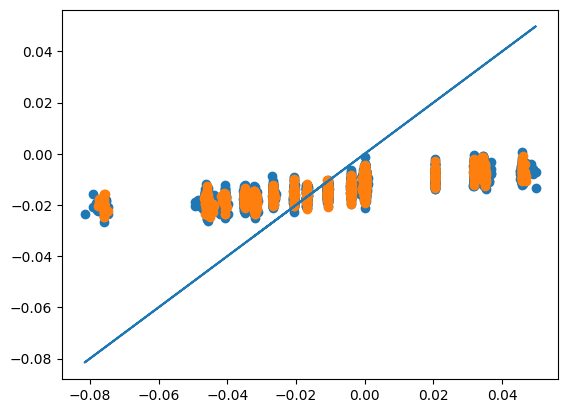

In [22]:
plt.scatter(y_train,train_pred)
plt.scatter(y_test,test_pred)
plt.plot(y_train, y_train)